In [8]:
import tweepy
import json
import pandas as pd
import re
import nltk
from textblob import TextBlob
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords, wordnet
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
import pandas as pd
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from matplotlib import pyplot
import csv
import sklearn

api_key = "aJTgi4d1H1zmQNkQuHeualNhP"
api_secrets = "yPFdp2Bbib25r1iPQCqBuPq8B9UzoJbIdpv1jgzEZFEg1eJl6X"
access_token = "1409382627124019204-oPpzVGuCwyFfQTfoocFhgHi68whhog"
access_secret = "esgwpH5gnRfNB0SpiHkO52mZSI5VKKnn8SG2pafEnzj2b"
 
# Authenticate to Twitter
auth = tweepy.OAuthHandler(api_key,api_secrets)
auth.set_access_token(access_token,access_secret)
 
api = tweepy.API(auth)

TWEET_OBJECT_PATH = 'tweet-objects/'

 
try:
    api.verify_credentials()
    print('Successful Authentication')
except:
    print('Failed Authentication')

Successful Authentication


In [4]:
def get_ids(filename):
    file = open(filename)
    threads = file.readlines()
    file.close()
    return [thread.replace('\n', '').split(',') for thread in threads]

def get_labels(filename):    
    file = open(filename)
    labels = file.readlines()
    file.close()
    return [label.replace('\n', '') for label in labels]

In [5]:
train_ids = get_ids('train.data.txt')
train_labels = get_labels('train.label.txt')

dev_ids = get_ids('dev.data.txt')
dev_labels = get_labels('dev.label.txt')

test_ids = get_ids('test.data.txt')

print(train_ids[0])
print()
print(train_labels[0])

['1250219300389974016', '1250219116993974272', '1250219437027766273', '1250219620939657216', '1250219777185873922', '1250219894429208577', '1250219998842216448', '1250220115762667520', '1250220272306638848', '1250220389323526146', '1250220527005753344', '1250220791544705025', '1250220987238383616', '1250221140603047937', '1250221275827470336', '1250221402822545410']

nonrumour


In [6]:
flat_train_ids = [id_ for id_list in train_ids for id_ in id_list]
flat_dev_ids = [id_ for id_list in dev_ids for id_ in id_list]
flat_test_ids = [id_ for id_list in test_ids for id_ in id_list]

unique_ids = list(set(flat_train_ids + flat_dev_ids))

In [213]:
# tweet id: full text of tweet if found by api, otherwise text from tweet-objects
tweets_dict = {}

def get_train_tweets_from_api(ids):
    for i in range(0, len(ids), 100):
        split = ids[i:i+100]
        for tweet in api.lookup_statuses(split, tweet_mode='extended'):
            tweets_dict[tweet.id_str] = tweet.full_text

def get_test_tweets(ids):
    for id_ in ids:
        file = open(f'tweet-objects/{id_}.json')
        tweet_object = json.load(file)
        file.close()
        tweets_dict[tweet_object['id_str']] = tweet_object['text']

In [214]:
get_train_tweets_from_api(unique_ids)
get_test_tweets(flat_test_ids)

print(tweets_dict[unique_ids[0]])
print(tweets_dict[unique_ids[-1]])
print(tweets_dict[flat_test_ids[0]])

Another Dark Day. @PwnParrot @Boogie2988
@TheValleyReport why are the hot ones so crazy? Cuz God says so. Mysterious ways whatever.
How Does COVID-19 Spread? https://t.co/TXHDeUpetg https://t.co/IyyirWcKSp


In [215]:
tweet_ids_df = pd.DataFrame({'id': tweets_dict.keys(), 'text': tweets_dict.values()}, index=tweets_dict.keys())
tweet_ids_df.head()

,id,text
552706985087361025,552706985087361025,This dog was abandoned at a Scottish railway s...
1250166679012872194,1250166679012872194,@TIME The problem \n\nis not corona!\n\nproble...
614613076432801792,614613076432801792,@petesouza @vj44 this president turns a once h...
519867203638657025,519867203638657025,“@ComplexMag: Someone spray painted a penis on...
674265577293156353,674265577293156353,@RollingStone there's some good news crime &am...


In [216]:
tweet_ids_df.to_csv('tweets_id_text.csv', header=True)

In [9]:
tweet_ids_df = pd.read_csv('tweets_id_text.csv', index_col=0) 
tweet_ids_df.head()

,id,text,user,verified,likes,retweets
1254347829365092357,1254347829365092357,@Gasbymalony @CACCOT1 Everything to these peop...,Kaymania3,False,2,0
523565690725617664,523565690725617664,@davidgrelle so what if it is Wilson didn't do...,Jeffmw,False,0,0
553603571200311296,553603571200311296,Yes!! 😎👍 RT “@SkyNews: Hostage-taker in superm...,Gm4nHere,False,0,0
521541390077943808,521541390077943808,"@TMZ wow, this saga will not end well regardless.",22lunamint,False,0,0
1252683209390739456,1252683209390739456,"ONS weekly deaths in London, UK, updated for w...",lenapatsa,False,4,1


In [10]:
def encode_label(label):
    # rumour: 1, nonrumour: 0
    if label == 'rumour':
        return 1
    return 0

def concatenate_tweets(source, reply_ids):
    concat = source
    
    for id_ in reply_ids:
        try:
            tweet = tweet_ids_df.loc[int(id_), 'text'] # may throw key error
            concat += ' ' + tweet
        except:
            continue
    concat = concat.strip()
    
    return concat

def create_dataframe(ids, labs, include_labels=True):
    source_ids = []
    reply_ids_list = []
    concat_tweets = []
    labels = []
    
    for i in range(len(ids)):
        # add concatenation of source and reply tweets to concat_tweets
        try:
            source = tweet_ids_df.loc[int(ids[i][0]), 'text'] # may throw key error
            if len(ids[i]) > 1:
                concat = concatenate_tweets(source, ids[i][1:])
            concat_tweets.append(concat)
        except:
            if include_labels:
                continue # skip instance if source tweet is missing
            else:
                concat_tweets.append('')

        # add id of source tweet to source_ids
        source_ids.append(ids[i][0])

        # add list of ids of reply tweets to reply_ids_list if there are replies
        if len(ids[i]) > 1:
            reply_ids_list.append(ids[i][1:])
        else:
            reply_ids_list.append([])              

        if include_labels:
            # add encoded label to labels (1 for rumour, 0 for nonrumour)
            label = encode_label(labs[i])
            labels.append(label)

    df = pd.DataFrame({'source_id': source_ids, 
                   'reply_ids': reply_ids_list,
                   'concat_tweet': concat_tweets})
    
    if include_labels:
        df['label'] = labels
    
    return df

In [11]:
train_full_df = create_dataframe(train_ids, train_labels)
train_full_df.head()

,source_id,reply_ids,concat_tweet,label
0,1250219300389974016,"[1250219116993974272, 1250219437027766273, 125...",5. Can regularly rinsing your nose with saline...,0
1,554886875303780352,"[554894001946759168, 554959644125167617, 55492...",French police chief killed himself after #Char...,1
2,1237901309011021825,"[1237901311439450112, 1239862502516760577]",Coronavirus disease (COVID-19) advice for the ...,0
3,524958128392376320,"[524961934064754688, 524959028061798401, 52495...",Ottawa police confirm that there were multiple...,0
4,1239295488677085185,[1239562248990806016],if the primary focus of a government isn't to ...,0


In [12]:
dev_full_df = create_dataframe(dev_ids, dev_labels)
dev_full_df.head()

,source_id,reply_ids,concat_tweet,label
0,1249004694950817796,[1249011200068730880],COVID-19 Fact:\nAre hand dryers effective in k...,0
1,1267552274819227649,"[1270394169836568576, 1270502071175909376]",@atruchecks when can we expect the result of m...,0
2,1235238334722699265,"[1235234904281165825, 1235234927937048577, 123...",How does COVID-19 spread? \n\nPeople can catch...,0
3,1248746792914546688,[1248775858120097792],"every news outlet using headlines like,\n\n""ar...",0
4,523820806917603328,"[523943560589361152, 524027059346370560, 53048...",Researcher @naskrecki on his encounter with a ...,0


In [13]:
test_full_df = create_dataframe(test_ids, None, include_labels=False)
test_full_df

,source_id,reply_ids,concat_tweet
0,1246482832316301319,[1247355493988909056],How Does COVID-19 Spread? https://t.co/TXHDeUp...
1,1252279738099433473,"[1251884146403815428, 1252033306100670464, 125...","@brain_warrior I hate to keep saying it, but C..."
2,1236050255394877440,"[1236050046950481922, 1236050331940855808]",Q. How are COVID-19 and influenza viruses diff...
3,1235582115900796928,"[1235584239497867275, 1235585067973578752, 123...",Una de les Q&amp;A on coronaviruses de la pàgi...
4,1258787515592572928,"[1258710626676899840, 1258711444075565058, 125...",@_truthpolitics We should absolutely blame the...
...,...,...,...
553,427944719612915712,"[427960532981665792, 427949634032783360, 42794...",Ex-Marlboro man dies from smoking-related dise...
554,531206167302012929,"[531228826496679936, 531255748157005825, 53120...",Holy shit. Doritos flavored Mountain Dew.\n\nA...
555,553099685888790528,"[553640547282608128, 557627319322685441, 55310...",Banksy account joins cartoonists support for #...
556,1222928724112396288,"[1222922750546923521, 1222929006967869442, 122...",@DrTedros @WHOWPRO @WHOSEARO @WHO_Europe @paho...


In [14]:
train_full_df.drop(['source_id','reply_ids'],axis=1,inplace=True)
dev_full_df.drop(['source_id','reply_ids'],axis=1,inplace=True)
test_full_df.drop(['source_id','reply_ids'],axis=1,inplace=True)
test_full_df

,concat_tweet
0,How Does COVID-19 Spread? https://t.co/TXHDeUp...
1,"@brain_warrior I hate to keep saying it, but C..."
2,Q. How are COVID-19 and influenza viruses diff...
3,Una de les Q&amp;A on coronaviruses de la pàgi...
4,@_truthpolitics We should absolutely blame the...
...,...
553,Ex-Marlboro man dies from smoking-related dise...
554,Holy shit. Doritos flavored Mountain Dew.\n\nA...
555,Banksy account joins cartoonists support for #...
556,@DrTedros @WHOWPRO @WHOSEARO @WHO_Europe @paho...


In [15]:
def preprocess_df(df):
    preprocessed = df
    text = list(preprocessed['concat_tweet'])
    sentiment = []
    for i in range(len(text)):
        text[i] = " ".join(filter(lambda x:x[0]!='@', text[i].split()))
        text[i] = " ".join(filter(lambda x:x[0:4]!='http', text[i].split()))
        text[i] = " ".join(filter(lambda x:x[0:4]!='&amp', text[i].split()))
        text[i] = re.sub(r'[^a-zA-Z ]','',text[i])
        text[i] = " ".join(filter(lambda x:x[0:1]!='Q', text[i].split()))
        text[i] = " ".join(filter(lambda x:x[0:1]!='A', text[i].split()))
        sentiment.append(TextBlob(text[i]).sentiment.polarity)
    preprocessed['concat_tweet'] = text 
    preprocessed.insert(1, 'sentiment',sentiment)
    preprocessed.fillna('', inplace=True)
    #sources.text = sources.text + " " + sources.hashtag
    return preprocessed

In [16]:
train_full_df = preprocess_df(train_full_df)
train_full_df.drop_duplicates(subset=['concat_tweet'][0:100],inplace=True)

dev_full_df = preprocess_df(dev_full_df)
dev_full_df.drop_duplicates(subset=['concat_tweet'][0:100],inplace=True)

test_full_df = preprocess_df(test_full_df)
test_full_df

,concat_tweet,sentiment
0,How Does COVID Spread Thanks WCCO You are the ...,0.183333
1,I hate to keep saying it but Capitalism will i...,-0.160000
2,How are COVID and influenza viruses different ...,0.100000
3,Una de les on coronaviruses de la pgina web de...,0.068466
4,We should absolutely blame the politicians and...,0.333333
...,...,...
553,ExMarlboro man dies from smokingrelated diseas...,0.174937
554,Holy shit Doritos flavored Mountain Dew is los...,0.043953
555,Banksy account joins cartoonists support for C...,0.083333
556,How are the members of an International Heal W...,0.233333


In [17]:
tt = TweetTokenizer()
stopwords = set(stopwords.words('english')) #note: stopwords are all in lowercase
lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()

def lemmatize(word):
    lemma = lemmatizer.lemmatize(word,'v')
    if lemma == word:
        lemma = lemmatizer.lemmatize(word,'n')
    return lemma

def tokenize_df(df):
    tokenized_df = df
    tokenized_sentence = []
    for _id, row in tokenized_df.iterrows():
        text = row['concat_tweet']
        # tokenize tweet
        tokens = tt.tokenize(text)
        # convert to lowercase
        tokens = [tok.lower() for tok in tokens]
        # remove stopwords
        tokens = [tok for tok in tokens if tok not in stopwords]
        # lemmatize
        tokens = [lemmatize(tok) for tok in tokens]
        tokenized_sentence.append(tokens)
    tokenized_df.insert(1, 'tokens', tokenized_sentence)
    tokenized_df.drop('concat_tweet',axis=1,inplace=True)
    return tokenized_df

In [18]:
train_full_df = tokenize_df(train_full_df)
train_full_df.head()

,tokens,sentiment,label
0,"[regularly, rinse, nose, saline, help, prevent...",0.173437,0
1,"[french, police, chief, kill, charliehebdo, at...",-0.278125,1
2,"[coronavirus, disease, covid, advice, public, ...",0.133333,0
3,"[ottawa, police, confirm, multiple, suspect, s...",0.133333,0
4,"[primary, focus, government, isnt, alleviate, ...",0.400000,0


In [19]:
dev_full_df = tokenize_df(dev_full_df)
dev_full_df.head()

,tokens,sentiment,label
0,"[covid, fact, hand, dryer, effective, kill, ne...",0.484091,0
1,"[expect, result, husband, pendingantibody, tes...",0.000000,0
2,"[covid, spread, people, catch, covid, others, ...",0.026257,0
3,"[every, news, outlet, use, headline, like, ant...",-0.056439,0
4,"[researcher, encounter, goliath, birdeater, wo...",0.168182,0


In [20]:
test_full_df = tokenize_df(test_full_df)
test_full_df

,tokens,sentiment
0,"[covid, spread, thank, wcco, station, trust, m...",0.183333
1,"[hate, keep, say, capitalism, implode, without...",-0.160000
2,"[covid, influenza, virus, different, covid, co...",0.100000
3,"[una, de, le, coronaviruses, de, la, pgina, we...",0.068466
4,"[absolutely, blame, politician, whoever, else,...",0.333333
...,...,...
553,"[exmarlboro, man, die, smokingrelated, disease...",0.174937
554,"[holy, shit, doritos, flavor, mountain, dew, l...",0.043953
555,"[banksy, account, join, cartoonist, support, c...",0.083333
556,"[member, international, heal, member, adviser,...",0.233333


In [21]:
def count_tokens(df):
    token_counts = {}
    for token_list in list(df['tokens']):
        for token in token_list:
            if token in token_counts:
                token_counts[token] += 1
            else:
                token_counts[token] = 1
    return {k: v for k, v in sorted(token_counts.items(), key=lambda item: item[1],reverse=True)}
            
unigram_counts = count_tokens(train_full_df)
unigram_counts

{'covid': 2250,
 'coronavirus': 1899,
 'people': 1639,
 'new': 1558,
 'virus': 1071,
 'get': 865,
 'say': 785,
 'like': 782,
 'dont': 645,
 'prevent': 609,
 'make': 588,
 'know': 581,
 'go': 580,
 'kill': 577,
 'spread': 550,
 'one': 534,
 'take': 533,
 'think': 528,
 'need': 519,
 'see': 510,
 'u': 495,
 'disease': 481,
 'would': 474,
 'hand': 473,
 'rt': 446,
 'test': 442,
 'good': 442,
 'person': 429,
 'symptom': 419,
 'protect': 412,
 'time': 406,
 'infect': 398,
 'use': 396,
 'infection': 391,
 'im': 381,
 'help': 374,
 'may': 371,
 'thats': 363,
 'day': 360,
 'spider': 360,
 'die': 351,
 'effective': 348,
 'work': 346,
 'cough': 336,
 'case': 336,
 'give': 334,
 'cause': 326,
 'death': 317,
 'want': 315,
 'someone': 314,
 'treat': 311,
 'report': 310,
 'mask': 306,
 'look': 304,
 'wear': 302,
 'come': 302,
 'shoot': 300,
 'catch': 298,
 'transmit': 295,
 'also': 293,
 'still': 282,
 'nose': 280,
 'way': 278,
 'even': 278,
 'thank': 274,
 'vaccine': 268,
 'find': 268,
 'china': 26

In [26]:
def top_n(df, n):
    return list(df.columns)+list(unigram_counts.keys())[0:n]

def df_top_tokens(df, cols):
    df_new = df
    df_new = df_new.reindex(columns=cols, fill_value=0)
    for i, row in df_new.iterrows():
        for token in row['tokens']:
            if token in list(df_new.columns):
                df_new.at[i, token] = 1
    df_new.drop(['tokens'],axis=1,inplace=True)
    return df_new


y_train = train_full_df['label']
y_dev = dev_full_df['label']

train_full_df.drop('label',axis=1,inplace=True)
dev_full_df.drop('label',axis=1,inplace=True)

cols_500 = top_n(train_full_df, 500)
cols_1000 = top_n(train_full_df, 1000)

train_df_500 = df_top_tokens(train_full_df, cols_500)
dev_df_500 = df_top_tokens(dev_full_df, cols_500)
test_df_500 = df_top_tokens(test_full_df, cols_500)

train_df_1000 = df_top_tokens(train_full_df, cols_1000)
dev_df_1000 = df_top_tokens(dev_full_df, cols_1000)
test_df_1000 = df_top_tokens(test_full_df, cols_1000)

In [27]:
train_df_500

,sentiment,covid,coronavirus,people,new,virus,get,say,like,dont,...,employee,reality,lord,attack,muslim,law,x,order,continue,post
0,0.173437,1,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-0.278125,0,0,0,0,0,1,0,1,1,...,0,0,0,1,0,0,0,0,0,0
2,0.133333,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.133333,0,0,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0.400000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1559,0.040770,1,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1560,-0.191270,0,0,0,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1561,0.031427,0,0,0,1,0,1,1,1,1,...,0,0,0,0,0,1,0,0,0,0
1562,-0.057692,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
scaler_500 = MinMaxScaler().fit(train_df_500['sentiment'].values.reshape(-1,1))
scaler_1000 = MinMaxScaler().fit(train_df_1000['sentiment'].values.reshape(-1,1))

train_df_500['sentiment'] = scaler_500.transform(train_df_500['sentiment'].values.reshape(-1,1))
dev_df_500['sentiment'] = scaler_500.transform(dev_df_500['sentiment'].values.reshape(-1,1))
test_df_500['sentiment'] = scaler_500.transform(test_df_500['sentiment'].values.reshape(-1,1))

train_df_1000['sentiment'] = scaler_1000.transform(train_df_1000['sentiment'].values.reshape(-1,1))
dev_df_1000['sentiment'] = scaler_1000.transform(dev_df_1000['sentiment'].values.reshape(-1,1))
test_df_1000['sentiment'] = scaler_1000.transform(test_df_1000['sentiment'].values.reshape(-1,1))

Train on 1552 samples, validate on 530 samples
Epoch 1/4000
1552/1552 [==============================] - 0s 269us/step - loss: 0.4325 - accuracy: 0.8106 - val_loss: 0.3844 - val_accuracy: 0.8245
Epoch 2/4000
1552/1552 [==============================] - 0s 150us/step - loss: 0.2364 - accuracy: 0.8930 - val_loss: 0.3016 - val_accuracy: 0.8642
Epoch 3/4000
1552/1552 [==============================] - 0s 150us/step - loss: 0.1200 - accuracy: 0.9581 - val_loss: 0.3269 - val_accuracy: 0.8868
Epoch 00003: early stopping
Train: 0.992, Test: 0.887


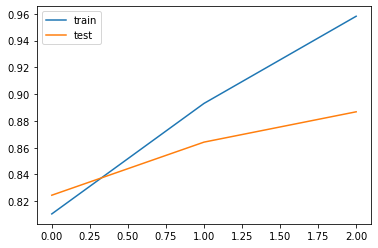

In [87]:
model_500 = Sequential()
model_500.add(Dense(501, activation='relu', input_shape=(501,)))
model_500.add(Dropout(0.2))
model_500.add(Dense(128, activation='relu'))
model_500.add(Dropout(0.2))
model_500.add(Dense(64, activation='relu'))
model_500.add(Dropout(0.2))
model_500.add(Dense(1, activation='sigmoid'))
model_500.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model_500.fit(train_df_500, y_train, validation_data=(dev_df_500, y_dev), epochs=4000, verbose=1, callbacks=[es])

_, train_acc = model_500.evaluate(train_df_500, y_train, verbose=0)
_, test_acc = model_500.evaluate(dev_df_500, y_dev, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

Train on 1552 samples, validate on 530 samples
Epoch 1/4000
1552/1552 [==============================] - 1s 755us/step - loss: 0.3747 - accuracy: 0.8241 - val_loss: 0.3126 - val_accuracy: 0.8660
Epoch 2/4000
1552/1552 [==============================] - 1s 626us/step - loss: 0.1230 - accuracy: 0.9626 - val_loss: 0.2902 - val_accuracy: 0.8906
Epoch 3/4000
1552/1552 [==============================] - 1s 628us/step - loss: 0.0404 - accuracy: 0.9878 - val_loss: 0.4121 - val_accuracy: 0.9094
Epoch 00003: early stopping
Train: 0.999, Test: 0.909


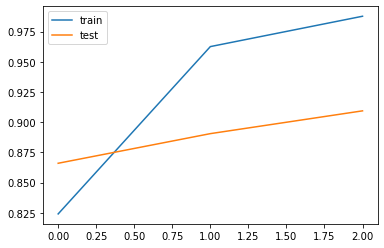

In [88]:
model_1000 = Sequential()
model_1000.add(Dense(1001, activation='relu', input_shape=(1001,)))
model_1000.add(Dropout(0.2))
model_1000.add(Dense(512, activation='relu'))
model_1000.add(Dropout(0.2))
model_1000.add(Dense(128, activation='relu'))
model_1000.add(Dropout(0.2))
model_1000.add(Dense(1, activation='sigmoid'))
model_1000.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model_1000.fit(train_df_1000, y_train, validation_data=(dev_df_1000, y_dev), epochs=4000, verbose=1, callbacks=[es])

_, train_acc = model_1000.evaluate(train_df_1000, y_train, verbose=0)
_, test_acc = model_1000.evaluate(dev_df_1000, y_dev, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [249]:
train_df_500

,sentiment,label,covid,coronavirus,people,new,virus,get,like,say,...,employee,continue,reality,lord,attack,law,x,order,post,id
0,0.586719,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.360938,0,0,0,0,0,0,1,1,0,...,0,0,0,0,1,0,0,0,0,0
2,0.566667,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.566667,0,0,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,0.700000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,0.520385,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1563,0.404365,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1564,0.505952,0,0,0,0,1,0,1,1,1,...,0,0,0,0,0,1,0,0,0,0
1565,0.471154,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [251]:
count = 0

for i in range(len(predictions_500)):
    if predictions_500[i] == predictions_1000[i]:
        count+=1
        
count/len(predictions_500)    

0.9139784946236559

In [ ]:
output_filename = 'nn_predictions_1000.csv'

header = ['Id', 'Predicted']
with open(output_filename, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    for i, pred in enumerate(predictions_1000):
        data = [str(i), str(pred)]
        writer.writerow(data)
    f.close()

In [253]:
test_df_500

,sentiment,label,covid,coronavirus,people,new,virus,get,like,say,...,employee,continue,reality,lord,attack,law,x,order,post,id
0,0.591667,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.420000,0,0,0,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0.550000,0,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.534233,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.666667,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553,0.587468,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
554,0.521977,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,1
555,0.541667,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
556,0.616667,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
train_df_scaled = pd.read_csv('train_df_scaled.csv')
dev_df_scaled = pd.read_csv('dev_df_scaled.csv')
test_df_scaled = pd.read_csv('test_df_scaled.csv')

train_df_rt_likes = pd.read_csv('train_df_rt_likes.csv')
dev_df_rt_likes = pd.read_csv('dev_df_rt_likes.csv')
test_df_rt_likes = pd.read_csv('test_df_rt_likes.csv')

train_df_rt_verified = pd.read_csv('train_df_rt_verified.csv')
dev_df_rt_verified = pd.read_csv('dev_df_rt_verified.csv')
test_df_rt_verified = pd.read_csv('test_df_rt_verified.csv')

train_df_verified_likes = pd.read_csv('train_df_verified_likes.csv')
dev_df_verified_likes = pd.read_csv('dev_df_verified_likes.csv')
test_df_verified_likes = pd.read_csv('test_df_verified_likes.csv')


train_df_users = pd.read_csv('train_df_users.csv')
dev_df_users = pd.read_csv('dev_df_users.csv')
test_df_users = pd.read_csv('test_df_users.csv')

y_train = pd.read_csv('y_train.csv')
y_dev = pd.read_csv('y_dev.csv')

for dataframe in [train_df_scaled,dev_df_scaled,test_df_scaled,
                  train_df_rt_likes,dev_df_rt_likes,test_df_rt_likes,
                  train_df_rt_verified,dev_df_rt_verified,test_df_rt_verified,
                  train_df_verified_likes,dev_df_verified_likes,test_df_verified_likes,
                  train_df_users,dev_df_users,test_df_users,
                  y_train, y_dev]:
    
    dataframe.drop("Unnamed: 0", axis =1, inplace=True)

Train on 1552 samples, validate on 530 samples
Epoch 1/4000
1552/1552 [==============================] - 1s 957us/step - loss: 0.3892 - accuracy: 0.8189 - val_loss: 0.2689 - val_accuracy: 0.8849
Epoch 2/4000
1552/1552 [==============================] - 1s 815us/step - loss: 0.1276 - accuracy: 0.9581 - val_loss: 0.3052 - val_accuracy: 0.8887
Epoch 00002: early stopping
Train: 0.991, Test: 0.889


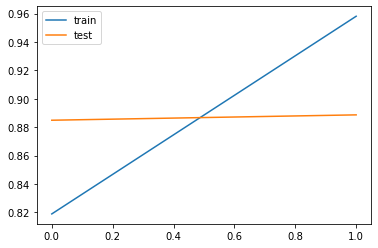

In [56]:
#users, rts, likes, verified
model_all = Sequential()
model_all.add(Dense(1162, activation='relu', input_shape=(1162,)))
model_all.add(Dropout(0.2))
model_all.add(Dense(512, activation='relu'))
model_all.add(Dropout(0.2))
model_all.add(Dense(128, activation='relu'))
model_all.add(Dropout(0.2))
model_all.add(Dense(1, activation='sigmoid'))
model_all.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model_all.fit(train_df_scaled, y_train, validation_data=(dev_df_scaled, y_dev), epochs=4000, verbose=1, callbacks=[es])

_, train_acc = model_all.evaluate(train_df_scaled, y_train, verbose=0)
_, test_acc = model_all.evaluate(dev_df_scaled, y_dev, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

Train on 1552 samples, validate on 530 samples
Epoch 1/4000
1552/1552 [==============================] - 1s 916us/step - loss: 0.4146 - accuracy: 0.8131 - val_loss: 0.3294 - val_accuracy: 0.8491
Epoch 2/4000
1552/1552 [==============================] - 1s 784us/step - loss: 0.1400 - accuracy: 0.9510 - val_loss: 0.3023 - val_accuracy: 0.8962
Epoch 3/4000
1552/1552 [==============================] - 1s 774us/step - loss: 0.0348 - accuracy: 0.9910 - val_loss: 0.4702 - val_accuracy: 0.9000
Epoch 00003: early stopping
Train: 0.997, Test: 0.900


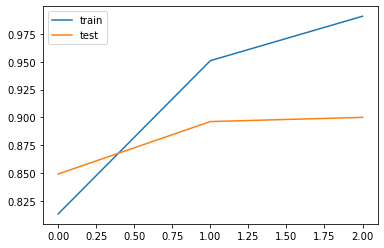

In [63]:
#users, rts, likes
model_rt_likes = Sequential()
model_rt_likes.add(Dense(1161, activation='relu', input_shape=(1161,)))
model_rt_likes.add(Dropout(0.2))
model_rt_likes.add(Dense(512, activation='relu'))
model_rt_likes.add(Dropout(0.2))
model_rt_likes.add(Dense(128, activation='relu'))
model_rt_likes.add(Dropout(0.2))
model_rt_likes.add(Dense(1, activation='sigmoid'))
model_rt_likes.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model_rt_likes.fit(train_df_rt_likes, y_train, validation_data=(dev_df_rt_likes, y_dev), epochs=4000, verbose=1, callbacks=[es])

_, train_acc = model_rt_likes.evaluate(train_df_rt_likes, y_train, verbose=0)
_, test_acc = model_rt_likes.evaluate(dev_df_rt_likes, y_dev, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

Train on 1552 samples, validate on 530 samples
Epoch 1/4000
1552/1552 [==============================] - ETA: 0s - loss: 0.3886 - accuracy: 0.82 - 1s 900us/step - loss: 0.3844 - accuracy: 0.8273 - val_loss: 0.2869 - val_accuracy: 0.8679
Epoch 2/4000
1552/1552 [==============================] - 1s 754us/step - loss: 0.1176 - accuracy: 0.9530 - val_loss: 0.3311 - val_accuracy: 0.9019
Epoch 00002: early stopping
Train: 0.988, Test: 0.902


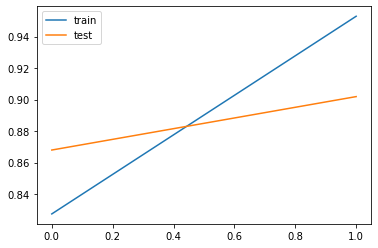

In [62]:
#users, rts, verified
model_rt_verified = Sequential()
model_rt_verified.add(Dense(1161, activation='relu', input_shape=(1161,)))
model_rt_verified.add(Dropout(0.2))
model_rt_verified.add(Dense(512, activation='relu'))
model_rt_verified.add(Dropout(0.2))
model_rt_verified.add(Dense(128, activation='relu'))
model_rt_verified.add(Dropout(0.2))
model_rt_verified.add(Dense(1, activation='sigmoid'))
model_rt_verified.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model_rt_verified.fit(train_df_rt_verified, y_train, validation_data=(dev_df_rt_verified, y_dev), epochs=4000, verbose=1, callbacks=[es])

_, train_acc = model_rt_verified.evaluate(train_df_rt_verified, y_train, verbose=0)
_, test_acc = model_rt_verified.evaluate(dev_df_rt_verified, y_dev, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

Train on 1552 samples, validate on 530 samples
Epoch 1/4000
1552/1552 [==============================] - 1s 886us/step - loss: 0.3728 - accuracy: 0.8312 - val_loss: 0.2998 - val_accuracy: 0.8717
Epoch 2/4000
1552/1552 [==============================] - 1s 761us/step - loss: 0.1399 - accuracy: 0.9555 - val_loss: 0.3128 - val_accuracy: 0.8887
Epoch 00002: early stopping
Train: 0.981, Test: 0.889


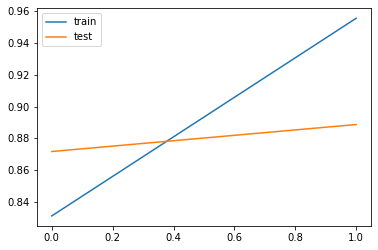

In [50]:
#users, verified, likes
model_verified_likes = Sequential()
model_verified_likes.add(Dense(1161, activation='relu', input_shape=(1161,)))
model_verified_likes.add(Dropout(0.2))
model_verified_likes.add(Dense(512, activation='relu'))
model_verified_likes.add(Dropout(0.2))
model_verified_likes.add(Dense(128, activation='relu'))
model_verified_likes.add(Dropout(0.2))
model_verified_likes.add(Dense(1, activation='sigmoid'))
model_verified_likes.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model_verified_likes.fit(train_df_verified_likes, y_train, validation_data=(dev_df_verified_likes, y_dev), epochs=4000, verbose=1, callbacks=[es])

_, train_acc = model_verified_likes.evaluate(train_df_verified_likes, y_train, verbose=0)
_, test_acc = model_verified_likes.evaluate(dev_df_verified_likes, y_dev, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

Train on 1552 samples, validate on 530 samples
Epoch 1/4000
1552/1552 [==============================] - 1s 919us/step - loss: 0.3849 - accuracy: 0.8312 - val_loss: 0.3187 - val_accuracy: 0.8717
Epoch 2/4000
1552/1552 [==============================] - 1s 761us/step - loss: 0.1081 - accuracy: 0.9633 - val_loss: 0.3211 - val_accuracy: 0.8868
Epoch 00002: early stopping
Train: 0.992, Test: 0.887


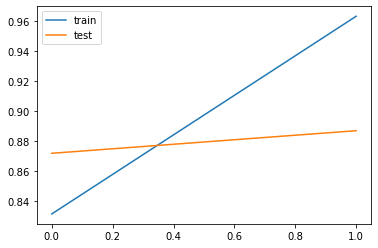

In [52]:
#users
model_users = Sequential()
model_users.add(Dense(1159, activation='relu', input_shape=(1159,)))
model_users.add(Dropout(0.2))
model_users.add(Dense(512, activation='relu'))
model_users.add(Dropout(0.2))
model_users.add(Dense(128, activation='relu'))
model_users.add(Dropout(0.2))
model_users.add(Dense(1, activation='sigmoid'))
model_users.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model_users.fit(train_df_users, y_train, validation_data=(dev_df_users, y_dev), epochs=4000, verbose=1, callbacks=[es])

_, train_acc = model_users.evaluate(train_df_users, y_train, verbose=0)
_, test_acc = model_users.evaluate(dev_df_users, y_dev, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [64]:
def convert_to_binary(x):
    if x < 0.5:
        return 0
    else:
        return 1

def predictions(model, df):
    return [convert_to_binary(y) for y in model.predict(df)]

predictions_all = predictions(model_all, test_df_scaled)
predictions_rt_likes = predictions(model_rt_likes, test_df_rt_likes)
predictions_rt_verified = predictions(model_rt_verified, test_df_rt_verified)
predictions_verified_likes = predictions(model_verified_likes, test_df_verified_likes)
predictions_users = predictions(model_users, test_df_users)

In [65]:
def output_predictions(filename, predictions):
    header = ['Id', 'Predicted']
    with open(filename, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(header)
        for i, pred in enumerate(predictions):
            data = [str(i), str(pred)]
            writer.writerow(data)
        f.close()
        
output_predictions('predictions_all.csv', predictions_all)
output_predictions('predictions_rt_likes.csv', predictions_rt_likes)
output_predictions('predictions_rt_verified.csv', predictions_rt_verified)
output_predictions('predictions_verified_likes.csv', predictions_verified_likes)
output_predictions('predictions_users.csv', predictions_users)

In [66]:
sklearn.metrics.classification_report(y_devpredictions_all

[1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,


In [67]:
predictions_all = predictions(model_all, dev_df_scaled)
predictions_rt_likes = predictions(model_rt_likes, dev_df_rt_likes)
predictions_rt_verified = predictions(model_rt_verified, dev_df_rt_verified)
predictions_verified_likes = predictions(model_verified_likes, dev_df_verified_likes)
predictions_users = predictions(model_users, dev_df_users)

In [84]:
class_names = ['nonrumour','rumour']

print(f'users, rts, likes, verified\n')
print(sklearn.metrics.classification_report(y_dev, predictions_all,target_names=class_names))
print()
print(f'users, rts, likes\n')
print(sklearn.metrics.classification_report(y_dev, predictions_rt_likes,target_names=class_names))
print()
print(f'users, rts, verified\n')
print(sklearn.metrics.classification_report(y_dev, predictions_rt_verified,target_names=class_names))
print()
print(f'users, verified, likes\n')
print(sklearn.metrics.classification_report(y_dev, predictions_verified_likes,target_names=class_names))
print()
print(f'users\n')
print(sklearn.metrics.classification_report(y_dev, predictions_users,target_names=class_names))
print()

users, rts, likes, verified

              precision    recall  f1-score   support

   nonrumour       0.95      0.91      0.93       419
      rumour       0.70      0.81      0.75       111

    accuracy                           0.89       530
   macro avg       0.83      0.86      0.84       530
weighted avg       0.90      0.89      0.89       530


users, rts, likes

              precision    recall  f1-score   support

   nonrumour       0.91      0.97      0.94       419
      rumour       0.85      0.63      0.73       111

    accuracy                           0.90       530
   macro avg       0.88      0.80      0.83       530
weighted avg       0.90      0.90      0.89       530


users, rts, verified

              precision    recall  f1-score   support

   nonrumour       0.94      0.93      0.94       419
      rumour       0.76      0.78      0.77       111

    accuracy                           0.90       530
   macro avg       0.85      0.86      0.85       530
we

In [89]:
pred_500 = predictions(model_500, dev_df_500)
pred_1000 = predictions(model_1000, dev_df_1000)

In [90]:
print(f'500\n')
print(sklearn.metrics.classification_report(y_dev, pred_500,target_names=class_names))
print()
print(f'1000\n')
print(sklearn.metrics.classification_report(y_dev, pred_1000,target_names=class_names))
print()

500

              precision    recall  f1-score   support

   nonrumour       0.91      0.95      0.93       419
      rumour       0.76      0.67      0.71       111

    accuracy                           0.89       530
   macro avg       0.84      0.81      0.82       530
weighted avg       0.88      0.89      0.88       530


1000

              precision    recall  f1-score   support

   nonrumour       0.95      0.94      0.94       419
      rumour       0.77      0.81      0.79       111

    accuracy                           0.91       530
   macro avg       0.86      0.87      0.87       530
weighted avg       0.91      0.91      0.91       530


